# Decision Trees 

## 1. Training and Visualizing

Decision Trees don't require feature scaling or centering.

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
x = iris.data[:, 2:]  # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(x, y)

DecisionTreeClassifier(max_depth=2)

In [2]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file='/tmp/iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True
)

In [3]:
!dot -Tpng /tmp/iris_tree.dot -o /tmp/iris_tree.png

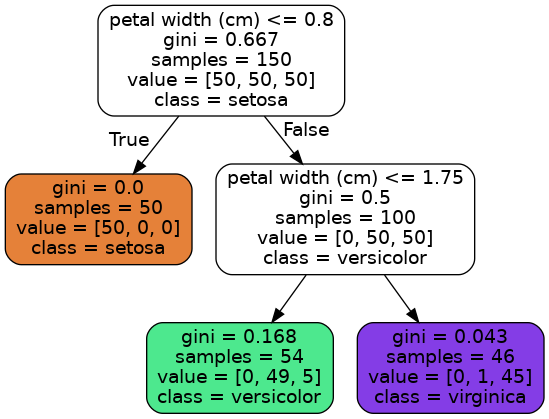

A node's `samples` attribute counts how many instances it applies to.  
A node's `value` attribute tells how many training instances of each class this node applies to.   
A node's `gini` attribute measures its *impurity*: a node is pure (`gini=0`) if all training instances it applies to belong to the same class.

## 2. Making Predictions

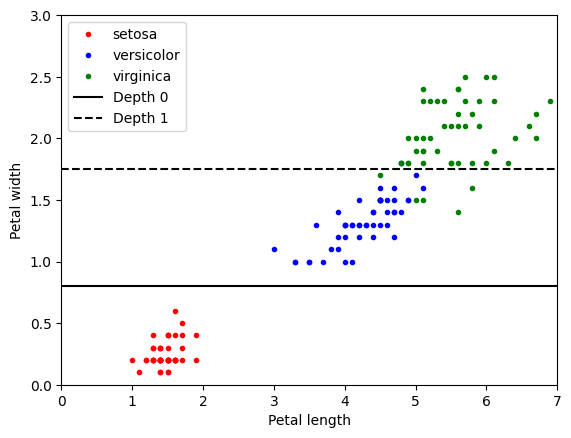

In [4]:
from matplotlib import pyplot as plt

setosa = y == 0
plt.plot(x[setosa][:, 0], x[setosa][:, 1], 'r.', label='setosa')
versicolor = y == 1
plt.plot(x[versicolor][:, 0], x[versicolor][:, 1], 'b.', label='versicolor')
virginica = y == 2
plt.plot(x[virginica][:, 0], x[virginica][:, 1], 'g.', label='virginica')

plt.plot([0, 7], [0.8, 0.8], 'k-', label='Depth 0')
plt.plot([0, 7], [1.75, 1.75], 'k--', label='Depth 1')

plt.xlabel('Petal length'); plt.ylabel('Petal width')
plt.xlim(0, 7); plt.ylim(0, 3)
plt.legend()
plt.show()

A Decision Tree can also estimate probability that an instance belongs to a particular class *k*.

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])

## 3. Regression

In [7]:
import numpy as np

np.random.seed(42)

m = 200
x = np.linspace(0, 1, m).reshape(m, 1)
y = 3 * x**2 - 2.9*x + .75 + .05* np.random.randn(m, 1)

In [8]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(x, y)

DecisionTreeRegressor(max_depth=2)

In [9]:
export_graphviz(
    tree_reg,
    out_file='/tmp/quadratic_tree.dot',
    feature_names=['x'],
    rounded=True,
    filled=True
)

In [10]:
!dot -Tpng /tmp/quadratic_tree.dot -o /tmp/quadratic_tree.png

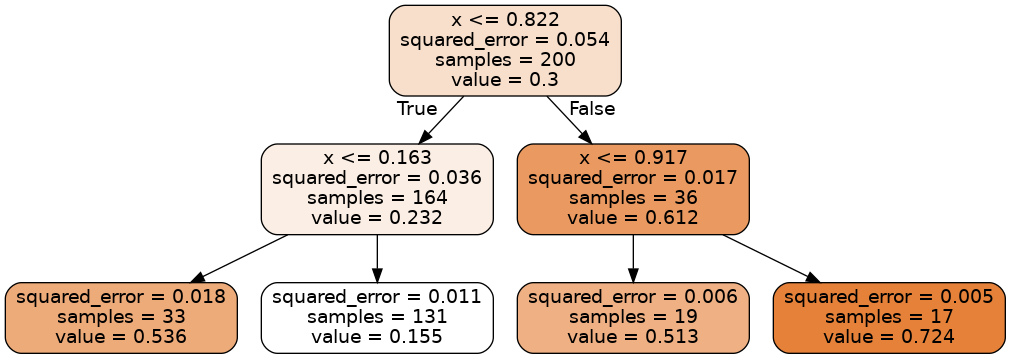

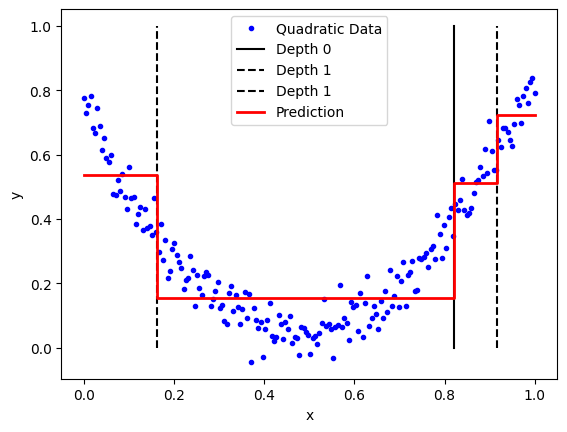

In [11]:
plt.plot(x, y, 'b.', label='Quadratic Data')
plt.plot([0.822, 0.822], [0, 1], 'k-', label='Depth 0')
plt.plot([0.163, 0.163], [0, 1], 'k--', label='Depth 1')
plt.plot([0.917, 0.917], [0, 1], 'k--', label='Depth 1')
plt.plot(
    [0, 0.163, 0.163, 0.822, 0.822, 0.917, 0.917, 1], 
    [0.536, 0.536, 0.155, 0.155, 0.513, 0.513, 0.724, 0.724], 
    'r-',
    linewidth=2,
    label='Prediction'
)

plt.xlabel('x'); plt.ylabel('y')
plt.legend()
plt.show()

## 4. Forest DIY

Grow a tree

In [12]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

moons = make_moons(n_samples=10000, noise=0.4)

x, y = moons

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

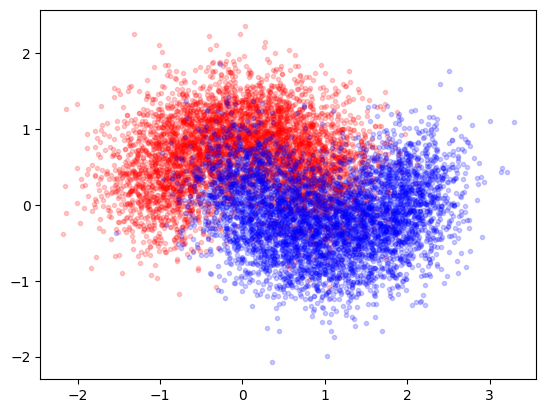

In [13]:
zeros, ones = y == 0, y == 1
plt.plot(x[zeros][:, 0], x[zeros][:, 1], 'r.', label='zeros', alpha=0.2)
versicolor = y == 1
plt.plot(x[ones][:, 0], x[ones][:, 1], 'b.', label='ones', alpha=0.2)

plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV

params = {
    'max_depth': [6, 7, 8, 9, 10, 12],
    'max_leaf_nodes': [26, 28, 30, 32]
}

tree_clf = DecisionTreeClassifier()

grid_search = GridSearchCV(tree_clf, params, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [6, 7, 8, 9, 10, 12],
                         'max_leaf_nodes': [26, 28, 30, 32]},
             return_train_score=True, scoring='accuracy')

In [15]:
grid_search.best_score_, grid_search.best_params_

(0.8556250000000001, {'max_depth': 7, 'max_leaf_nodes': 26})

In [16]:
from sklearn.metrics import accuracy_score

final_model = grid_search.best_estimator_

final_predictions = final_model.predict(x_test)

final_accuracy = accuracy_score(y_test, final_predictions)
final_accuracy

0.86

Now grow a forest!

In [17]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(x_train) - n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(x_train):
    x_mini_train = x_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((x_mini_train, y_mini_train))

In [18]:
from sklearn.base import clone

forest = [clone(grid_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (x_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(x_mini_train, y_mini_train)
    
    y_pred = tree.predict(x_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.7933104999999999

In [19]:
y_pred = np.empty([n_trees, len(x_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    y_pred[tree_index] = tree.predict(x_test)

In [20]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(y_pred, axis=0, keepdims=True)

In [21]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8595